In [2]:
import numpy as np
import open3d as o3d
import scipy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import odl
import mcubes

import sys
sys.path.append('..')
mesh = o3d.io.read_triangle_mesh("Stanford_Bunny.stl")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
from hubconf import *

In [4]:
downpcd = mesh.sample_points_uniformly(20000)
psn = PoissonNetFull()

c:\Users\Hege\anaconda3\envs\ai\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Now we can normalize the point cloud to $[0,1]^3$:

In [5]:
downpcd.scale(1 / np.max(downpcd.get_max_bound() - downpcd.get_min_bound()),
               center=downpcd.get_center())
downpcd.translate(- downpcd.get_min_bound())

PointCloud with 20000 points.

We can use Open3D's built-in method to calculate normals:

In [6]:
downpcd.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1,
                                                          max_nn=500))
downpcd.orient_normals_consistent_tangent_plane(100)

Now we convert the points cloud and to normals to a vector field by smoothing:

In [7]:
# Show the point cloud in open3d
o3d.visualization.draw_geometries([downpcd], point_show_normal=True)


In [8]:
points = np.asarray(downpcd.points)
normals = np.asarray(downpcd.normals)
points = torch.from_numpy(points).float().unsqueeze(0).cuda()
normals = torch.from_numpy(normals).float().unsqueeze(0).cuda()

In [9]:
res = psn(points, normals)

torch.Size([1, 3, 64, 64, 64])
torch.Size([1, 64, 64, 64])
UnitGaussianNormalizer init on 1, reducing over [0], samples of shape [64, 64, 64].
   Mean and std of shape torch.Size([64, 64, 64]), eps=1e-05
torch.Size([1, 64, 64, 64, 64])


In [19]:
res_numpy = res.squeeze(0).cpu().detach().numpy()

In [24]:
normals

array([[ 0.57490632, -0.03850751, -0.81731261],
       [ 0.56811894, -0.05284148, -0.82124823],
       [ 0.55148186, -0.02104289, -0.83392143],
       ..., 
       [ 0.06268085,  0.44145059,  0.89509356],
       [-0.0103219 ,  0.45687827,  0.88946934],
       [ 0.33399842,  0.17981395,  0.92526321]])

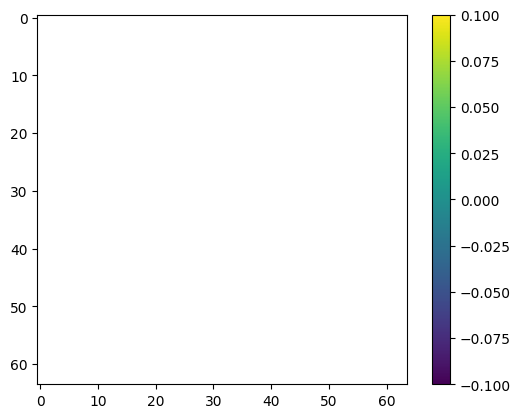

In [20]:
plt.imshow(res_numpy[:,20,:])
plt.colorbar()
plt.show()

In [10]:
grid_size = 50
normals = np.asarray(downpcd.normals)
xyz = np.asarray(downpcd.points)
data = np.round((50-1)*xyz)
field_V = np.zeros((grid_size, grid_size, grid_size, 3)) #Divergence of \overrightarrow{V}
density_tensor_binary = np.zeros((grid_size, grid_size, grid_size)) # Density of points, so we can normalize
for i in range(data.shape[0]):
  density_tensor_binary[round(data[i,0]), round(data[i,1]), round(data[i,2])] += 1
density_tensor = scipy.ndimage.filters.gaussian_filter(np.pad(density_tensor_binary,((5,), (5,), (5,))), 2) #Smoothed density
for i in range(data.shape[0]):
  field_V[round(data[i,0]), round(data[i,1]), round(data[i,2])] += normals[i] / density_tensor[round(data[i,0]) + 5, round(data[i,1]) + 5, round(data[i,2]) + 5]

C:\Users\Hege\AppData\Local\Temp\ipykernel_6764\862607938.py:9: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  density_tensor = scipy.ndimage.filters.gaussian_filter(np.pad(density_tensor_binary,((5,), (5,), (5,))), 2) #Smoothed density


In [11]:
field_V = np.pad(field_V,((3,), (3,), (3,),(0,)))
divergernce_tensor = np.zeros(field_V.shape[:3])
for i in range(3):
  divergernce_tensor += np.roll(field_V, 1, axis = i)[:,:,:,i] - field_V[:,:,:,i]
divergernce_tensor = scipy.ndimage.filters.gaussian_filter(divergernce_tensor,2)

C:\Users\Hege\AppData\Local\Temp\ipykernel_6764\2760148577.py:5: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  divergernce_tensor = scipy.ndimage.filters.gaussian_filter(divergernce_tensor,2)


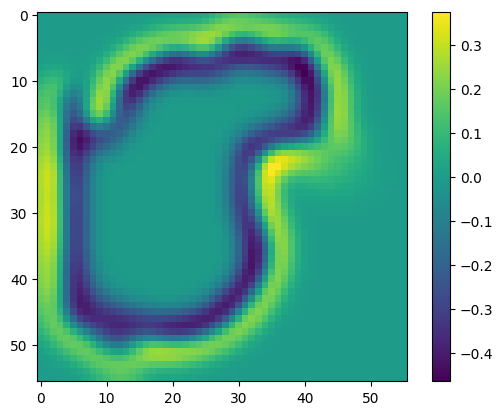

In [12]:
plt.imshow(divergernce_tensor[:,20,:])
plt.colorbar()
plt.show()

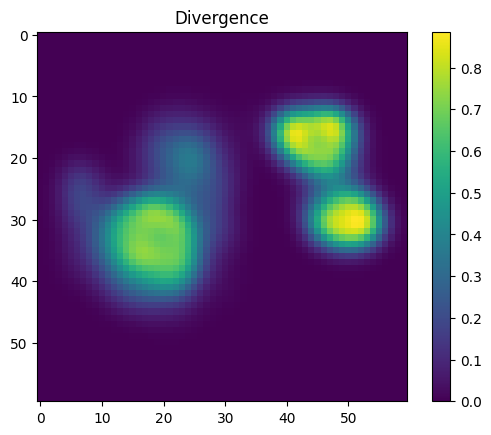

In [13]:
plt.imshow(density_tensor[:,35,:])
plt.colorbar()
plt.title("Divergence")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


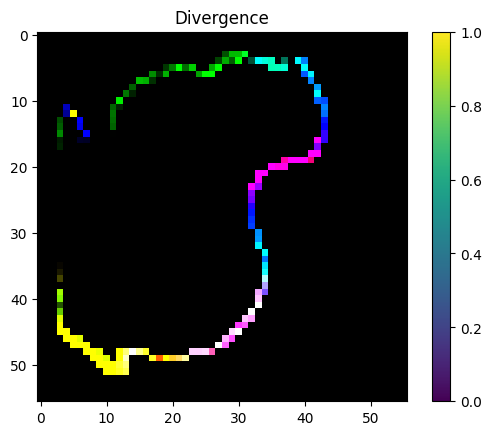

In [14]:
plt.imshow(field_V[:,20,:])
plt.colorbar()
plt.title("Divergence")
plt.show()

For a ground truth we voxelize and fill in the the shape directly. The process is quite hacky, but works for the bunny at least.

In [15]:
from skimage.morphology import flood_fill

def heuristic_fill(binary_array):
    """Aan ad hoc way of filling in the center of a voxelized version of the input points, using flood fill on a smoothed version to avoid holes. Might fail if the random points were chosen far apart.
    """
    smoothed = np.clip(scipy.ndimage.filters.gaussian_filter(binary_array, 1), a_min=.01, a_max=1)
    grid_center = tuple(i//3 for i in binary_array.shape)
    print(grid_center)
    vaguely_filled_center = np.clip( np.round(flood_fill(smoothed, grid_center, 1) + binary_array), a_min=0, a_max=1)
    result = scipy.ndimage.filters.gaussian_filter(vaguely_filled_center, 2) > 0.52
    return result

GT = np.pad(density_tensor_binary, 3)
GT = heuristic_fill(GT) #Ground thruth binary mask, indicator function of the bunny

(18, 18, 18)


C:\Users\Hege\AppData\Local\Temp\ipykernel_6764\957371252.py:6: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  smoothed = np.clip(scipy.ndimage.filters.gaussian_filter(binary_array, 1), a_min=.01, a_max=1)
C:\Users\Hege\AppData\Local\Temp\ipykernel_6764\957371252.py:10: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  result = scipy.ndimage.filters.gaussian_filter(vaguely_filled_center, 2) > 0.52


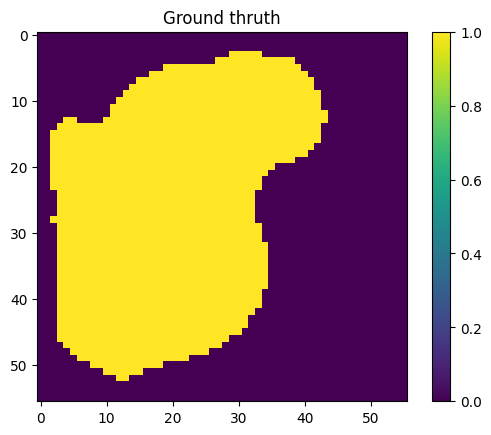

In [16]:
plt.imshow(GT[:,17,:])
plt.colorbar()
plt.title("Ground thruth")
plt.show()

In [17]:
space = odl.space.NumpyTensorSpace(divergernce_tensor.shape, dtype = np.float)

class Laplacian(odl.Operator):
    def __init__(self):
      super(Laplacian, self).__init__(
            domain=space, range=space, linear=True)

    def _call(self, x):
      return scipy.ndimage.laplace(x)
    
    @property
    def adjoint(self):
      return self

mask = space.element(np.pad(density_tensor_binary,3)> 0.5)
mask_op = odl.operator.default_ops.MultiplyOperator(mask)
A = Laplacian()
lin_ops = [A, mask_op]
a = 0.2
b = 0.00005
g = space.element(divergernce_tensor)
# Create functionals for the l2 distance and l1 norm.
g_funcs = [odl.solvers.L2NormSquared(space).translated(g), a * odl.solvers.L2NormSquared(space)]

# Functional of the bound constraint 0 <= x <= 1
f = odl.solvers.functional.default_functionals.ZeroFunctional(space)

# Find scaling constants so that the solver converges.
# See the douglas_rachford_pd documentation for more information.
opnorm_A = odl.power_method_opnorm(A, xstart=g)
#opnorm_B = odl.power_method_opnorm(B)
opnorm_mask = 1
sigma = [1 / opnorm_A ** 2, 1 / opnorm_mask ** 2]
tau = 1.0

# Solve using the Douglas-Rachford Primal-Dual method
x = space.zero()
odl.solvers.douglas_rachford_pd(x, f, g_funcs, lin_ops,
                                tau=tau, sigma=sigma, niter=1000)
x.show('TV Douglas-Rachford', force_show=True)
binary_result = x.asarray() >= 0

C:\Users\Hege\AppData\Local\Temp\ipykernel_6764\719206268.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  space = odl.space.NumpyTensorSpace(divergernce_tensor.shape, dtype = np.float)


KeyboardInterrupt: 

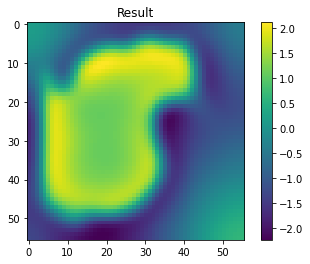

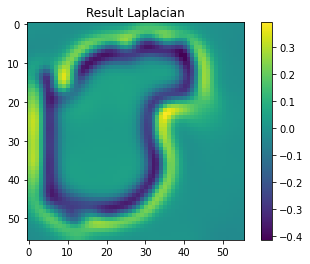

In [ ]:
plt.imshow(x[:,20,:])
plt.colorbar()
plt.title("Result")
plt.show()
plt.imshow(A(x)[:,20,:])
plt.colorbar()
plt.title("Result Laplacian")
plt.show()

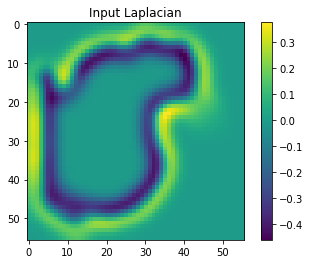

In [ ]:
plt.imshow(divergernce_tensor[:,20,:])
plt.colorbar()
plt.title("Input Laplacian")
plt.show()

We can also compare the binarized versions:

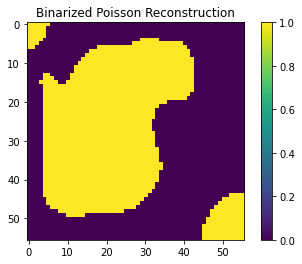

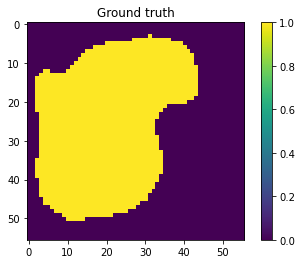

In [ ]:
plt.imshow(binary_result[:,20,:])
plt.colorbar()
plt.title("Binarized Poisson Reconstruction")
plt.show()
plt.imshow(GT[:,20,:])
plt.colorbar()
plt.title("Ground truth")
plt.show()

We can export the resulting surface as a mesh:

In [ ]:
def export_array(array, path, level):
    vertices, triangles = mcubes.marching_cubes(array, level)
    mcubes.export_mesh(vertices, triangles, path, "Reconstruction")
export_array(x.asarray(), "bunny.dae", 0)

We can also normalize the normalized Laplacians of out ground truth and our resulting function c with the divergence calculated from the point cloud, and see that they are very close:

In [ ]:
GT_laplacian = A(GT)
norm1 = GT_laplacian / np.linalg.norm(GT_laplacian)
norm2 = A(x)/np.linalg.norm(A(x))
norm3 = divergernce_tensor / np.linalg.norm(divergernce_tensor)
print(np.linalg.norm(norm1 - norm2))
print(np.linalg.norm(norm1 - norm3))
print(np.linalg.norm(norm2 - norm3))

1.33145560762
1.33203706823
0.205047977883


We can also export the point cloud for comparison:

In [ ]:
o3d.io.write_point_cloud("points.ply", downpcd)

True